# 문제 1.

  - 피마 인디언 당뇨병 발병여부를 예측할 수 있는 분석 모델을 구현하기 위해 아래와 같은 항목들을 조사하였다. 분석하라.

  - 단, 모든 독립변수는 명목형 변수를 포함하지 않으며 정규분포를 만족한다고 가정한다.

  | 변수 | 설명 |
  |---|---|
  | Pregnancies | 임신횟수 |
  | Glucose | 포도당 부하 검사 수치 |
  | BloodPressure | 혈압 |
  | SkinThickness | 팔 삼두근 뒤쪽의 피하지방 측정값 |
  | Insulin | 혈청 인슐린 |
  | BMI | 체질량 지수 |
  | DiabetesPedigreeFunction | 당뇨 내력 가중치 값 |
  | Age | 나이 |
  | Outcome |	당뇨여부(0 또는 1) |

In [7]:
from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sb
import numpy as np
from patsy import dmatrix
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from helper import my_logit, scalling

In [4]:
df = read_excel('https://data.hossam.kr/E05/indian_diabetes.xlsx')
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [6]:
ddf = df.copy()
ddf.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [8]:
model = logit('Outcome~Pregnancies+Glucose+BloodPressure+SkinThickness+Insulin+BMI+DiabetesPedigreeFunction+Age', data = ddf)
fit = model.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Mon, 31 Jul 2023   Pseudo R-squ.:                  0.2718
Time:                        15:37:37   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -8.4047      0.717    -11.728      0.000      -9.809

In [9]:
fit.prsquared

0.27180966859224576

In [14]:
ddf['예측값'] = fit.predict(ddf.drop('Outcome', axis = 1))
ddf['예측결과'] = ddf['예측값'] > 0.5
ddf

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome       예측값   예측결과  
0                       0.627   50        1  0.721727   True  
1                       0.351   31        0  0.048642  False  
2                       0.672   32        1  0.796702   True  
3                       0.167   21        0  0.041625  False  
4                       2.288   33        1  0.902184   True  
..                        ...  ...      ...       ...    ...  
763                     0.171   63        0  0.317115  False  
764                     0.340   27        0  0.318969  False  
765                     0.245   30        0  0.170416  False  
766                     0.349   47        1  0.284976  False  
767                     0.315   23        0  0.072014  False  

[768 rows x 11 columns]

In [15]:
cm = confusion_matrix(ddf['Outcome'], ddf['예측결과'])
tn, fp, fn, tp = cm.ravel()

print(tn, fp, fn, tp)

cmdf = DataFrame([[tn,tp],[fn,fp]], index = ['True', 'False'], columns = ['Negative', 'Positive'])
cmdf

445 55 112 156


Negative  Positive
True        445       156
False       112        55

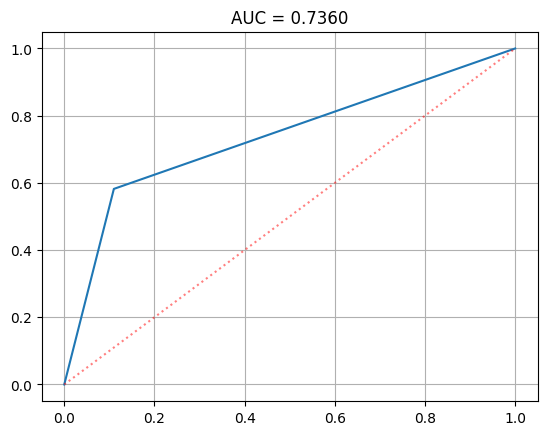

In [16]:
ras = roc_auc_score(ddf['Outcome'], ddf['예측결과'])

# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(ddf['Outcome'], ddf['예측결과'])

plt.figure()
sb.lineplot(x = fpr, y = tpr)
sb.lineplot(x = [0,1], y = [0,1], color = 'red', linestyle = ':', alpha = 0.5)
plt.title('AUC = {:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [17]:
# 정확도
acc = accuracy_score(ddf['Outcome'], ddf['예측결과'])

# 정밀도
pre = precision_score(ddf['Outcome'], ddf['예측결과'])

# 재현율
recall = recall_score(ddf['Outcome'], ddf['예측결과'])

# F1 score
f1 = f1_score(ddf['Outcome'], ddf['예측결과'])

# 위양성율
fallout = fp / (fp + tn)

# 특이성
spe = 1 - fallout

result_df = DataFrame({'설명력(Pseudo-Rsqe)': [fit.prsquared], '정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})

result_df.T      

0
설명력(Pseudo-Rsqe)       0.271810
정확도(Accuracy)          0.782552
정밀도(Precision)         0.739336
재현율(Recall, TPR)       0.582090
위양성율(Fallout, FPR)     0.110000
특이성(Specificity, TNR)  0.890000
RAS                    0.736045
f1_score               0.651357

# 문제 2.

  - 다음의 데이터는 타이타닉 탑승객 명단 데이터이다. 적절한 데이터 전처리와 정제를 수행한 후 분석하라.

  - 단, 모든 독립변수는 정규분포를 만족한다고 가정한다.

| 변수명 | 설명 |
|---|---|
| PassengerId | 탑승객의 ID(인덱스와 같은 개념) |
|Survived| 생존유무(0은 사망 1은 생존) |
| Pclass | 객실의 등급 |
| Name | 이름 |
| Sex | 성별 |
| SibSp | 동승한 형제 혹은 배우자의 수 |
| Parch | 동승한 자녀 혹은 부모의 수 |
| Ticket | 티켓번호 |
| Fare | 요금 |
| Cabin |	선실 |
| Embarked | 탑승지 (C = Cherbourg, Q = Queenstown, S = Southampton) |


In [3]:
tf = read_excel('https://data.hossam.kr/E05/titanic.xlsx')
tf

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [28]:
tdf = df.copy()
tdf.drop(columns = ['PassengerId','Name', 'Ticket'], axis = 1)
tdf.head()

KeyError: "['PassengerId', 'Name', 'Ticket'] not found in axis"